In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 11, 12)

In [3]:
DATA = '../data'

sp1950 = pd.read_csv(f'{DATA}/sp1950.csv')
nya1965 = pd.read_csv(f'{DATA}/nya1965.csv')
nasdaq1965 = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wilshire1990 = pd.read_csv(f'{DATA}/wilshire1990.csv')


nasdaq1965.tail()
states = pd.read_csv(f'{DATA}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2022-11-07,2022-11-07,3806.800049,1.009614,0.999942,14808.629883,1.007200,0.999845,10564.519531,1.008522,1.000448,37959.371094,1.008607,0.99956,0.999949,0
2022-11-08,2022-11-08,3828.110107,1.005598,0.999942,14889.299805,1.005447,0.999845,10616.200195,1.004892,1.000448,38151.441406,1.005060,0.99956,0.999949,0
2022-11-09,2022-11-09,3748.570068,0.979222,0.999942,14587.759766,0.979748,0.999845,10353.169922,0.975224,1.000448,37306.441406,0.977851,0.99956,0.999949,0
2022-11-10,2022-11-10,3956.370117,1.055434,0.999942,15234.719727,1.044350,1.012514,11114.150391,1.073502,1.000448,39420.308594,1.056662,0.99956,1.003116,6
2022-11-11,2022-11-11,3992.929932,1.009241,0.999942,15352.687500,1.007743,1.000781,11323.331055,1.018821,1.000448,39835.621094,1.010535,0.99956,1.000183,1


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ACN', 'ADBE', 'ADYEY', 'AMD', 'AMGN',
    'AMZN', 'ANET', 'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'CRWD',
    'DDOG', 'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'GH',
    'GMED', 'GOOG', 'IDXX', 'INTG', 'ISRG', 'JD', 'LRCX', 'LSPD',
    'LULU', 'MA', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NET', 'NVCR',
    'NVDA', 'ODFL', 'OKTA', 'OPEN', 'PAC', 'PANW', 'PAYC', 'PINS',
    'PTON', 'PYPL', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'RIVN', 'RMD',
    'ROKU', 'RVLV', 'SBUX', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC',
    'TEAM', 'TREX', 'TSCO', 'TSLA', 'TTD', 'TTWO', 'TWLO', 'TWTR',
    'TYL', 'UPST', 'VEEV', 'VLD', 'VRTX', 'XPEV', 'ZEN', 'ZM']
LINGERERS = [
    'AGI', 'AMEH', 'AMRK', 'APT', 'BTTR', 'BYRN', 'CEF', 'CENN',
    'CGAU', 'CIZN', 'CTGO', 'DTST', 'DYAI', 'EP', 'FCUV', 
    'GCBC', 'GME', 'HMY', 'IDR', 'IEI', 'INTZ', 'KREF',
    'MCVT', 'MICS', 'MIY', 'MNMD', 'MOBQ', 'MTA', 'NAN', 'OMQS',
    'PETV', 'POWW', 'PRPH', 'RVP', 'RVYL', 'SOBR', 'VIRT', 'WAVD',
    'WKHS', 'ZYXI']
BEST_WEIGHTED = [
    'AMRC', 'CF', 'CHEF', 'COOP', 'CSIQ', 'CTSH', 'CVE', 'DQ',
    'ELC', 'ENPH', 'FKWL', 'GGE', 'HBM', 'LFMD', 'NTAP', 'PACB',
    'PAYS', 'RFP']
len(SYMBOLS)

81

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 11, 14), datetime.date(2022, 11, 12))

In [6]:
batch = sorted(list(set(SYMBOLS + LINGERERS + BEST_WEIGHTED)))

In [7]:
data = (
    yf
    .download(batch, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'})
    .sort_index())

[*********************100%***********************]  139 of 139 completed


In [8]:
data['state'] = states.state
data.tail()

AdjClose                                                         \
                  AAPL        ABMD        ABNB         ACN        ADBE  ADYEY   
Date                                                                            
2022-11-07  138.919998  373.290009   95.459999  269.070007  299.540009  12.76   
2022-11-08  139.500000  374.000000   98.900002  269.029999  302.170013  13.04   
2022-11-09  134.869995  374.000000   95.790001  266.440002  298.869995  13.01   
2022-11-10  146.869995  372.779999  102.400002  287.019989  329.950012  15.43   
2022-11-11  149.699997  373.989990  109.570000  290.089996  341.149994  16.73   

                                                    ...     Volume             \
             AGI        AMD       AMEH        AMGN  ...       VIRT        VLD   
Date                                                ...                         
2022-11-07  7.97  63.080002  36.009998  277.019989  ...   650200.0  1483200.0   
2022-11-08  8.44  63.849998  37.169998  292.390015  ...  1131800.0  1592200.0   
2022-11-09  8.29  59.919998  36.180000  289.649994  ...   917800.0  4968400.0   
2022-11-10  8.88  68.470001  36.330002  291.010010  ...  1342000.0  2663500.0   
2022-11-11  8.88  72.370003  36.590000  285.019989  ...  1340361.0  2749529.0   

                                                                               \
               VRTX   WAVD     WKHS        XPEV        ZEN         ZM    ZYXI   
Date                                                                            
2022-11-07  1560100  28800  3939900  48472800.0  2400800.0  3317800.0  291400   
2022-11-08  1356600   4400  4097700  23536100.0  4958000.0  3987100.0  204300   
2022-11-09  1321400  23100  3512700  27736800.0  4642600.0  6019800.0  171300   
2022-11-10  2112600  27600  8338400  37479000.0  1254800.0  4908600.0  175300   
2022-11-11  2123407   6406  8459149  62336878.0   972677.0  5902654.0  180348   

           state  
                  
Date              
2022-11-07     0  
2022-11-08     0  
2022-11-09     0  
2022-11-10     6  
2022-11-11     1  

[5 rows x 835 columns]

In [9]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [10]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

1

In [11]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = (
        sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0])
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [12]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [13]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [14]:
def get_hedged_sharpe(daily_returns, data):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return min(state_sharpe, lower_state_sharpe, upper_state_sharpe)

In [15]:
def get_weighted_sharpe(daily_returns, data, weights=[0.2, 0.6, 0.2]):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return (
        weights[0]*lower_state_sharpe
        + weights[1]*state_sharpe
        + weights[2]*upper_state_sharpe)

In [16]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [17]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [18]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [19]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [20]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [21]:
EXAMPLE = 'AAPL'

In [22]:
stock_data = get_stock_data(EXAMPLE, data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
(get_sharpe(daily_returns), 
 get_sharpe(daily_returns[data.state == CURRENT_STATE]))

(0.9035083318085041, 1.6617730518932348)

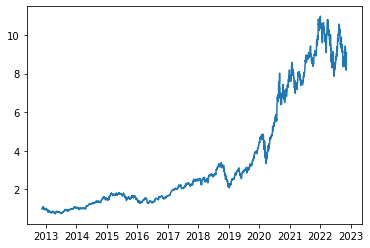

In [23]:
plt.plot(
    (get_daily_returns(data[('AdjClose', EXAMPLE)]) + 1).cumprod());

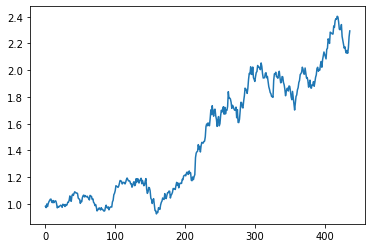

In [24]:
dr = get_daily_returns(
    data[('AdjClose', EXAMPLE)]
)[data.state == CURRENT_STATE]
dr = dr[dr.notnull()]
plt.plot((dr + 1).to_numpy().cumprod());

In [25]:
get_weighted_sharpe(daily_returns, data.copy())

0.43376294084001144

In [26]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #hedged_sharpe = get_hedged_sharpe(daily_returns, data)
    weighted_sharpe = get_weighted_sharpe(daily_returns, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.AdjClose 
         + stock_data.High 
         + stock_data.Low 
         + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    n_notnull_resid = stock_data.resid.notnull().sum()
    stock_data['dev'] = np.nan
    stock_data.loc[stock_data.resid.notnull(), 'dev'] = (
        np.array(range(n_notnull_resid) / n_notnull_resid))
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.AdjClose, label='AdjClose')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],
        stock_data.rsi.tolist()[-1],
        stock_data.resid.tolist()[-1], 
        stock_data.dev.tolist()[-1],
        stock_data.drawdown.tolist()[-1],
        stock_data.pullup.tolist()[-1],
        sharpe,
        #state_sharpe,
        #hedged_sharpe,
        weighted_sharpe)

(1,
 0.4830203755493408,
 0.9328565752880413,
 0.9328565752880413,
 0.1876305892185541,
 0.2636857501044714,
 0.9035083318085041,
 0.43376294084001144)

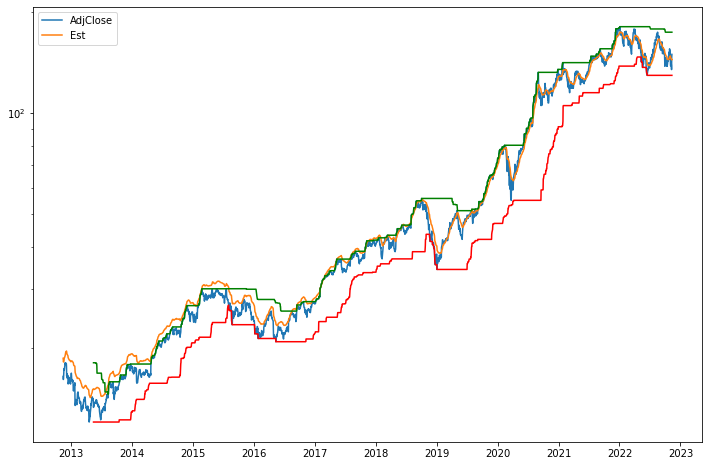

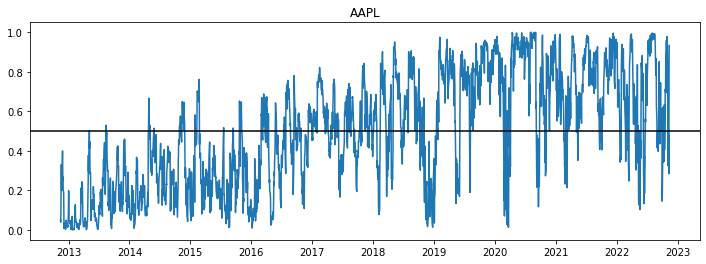

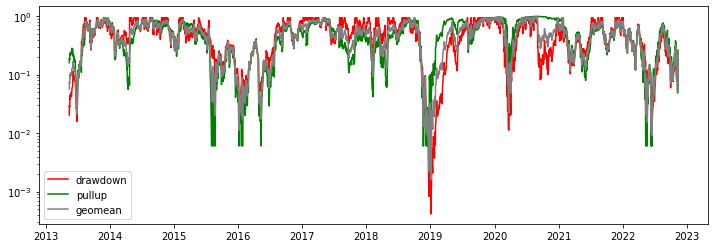

In [27]:
process_stock('AAPL', data.copy(), plot=True)

In [28]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    stock_stats = process_stock(stock, data)
    out.append([stock, *stock_stats])

AAPL... ABMD... ABNB... ACN... ADBE... ADYEY... AGI... AMD... AMEH... AMGN... AMRC... AMRK... AMZN... ANET... APT... ASML... AXON... BROS... BTTR... BYND... BYRN... CEF... CENN... CF... CGAU... CHEF... CHWY... CIZN... COOP... CRWD... CSIQ... CTGO... CTSH... CVE... DDOG... DOCS... DOCU... DQ... DTST... DUOL... DYAI... EDIT... ELC... ENPH... EP... ETSY... FCUV... FKWL... FLGT... GCBC... GGE... GH... GME... GMED... GOOG... HBM... HMY... IDR... IDXX... IEI... INTG... INTZ... ISRG... JD... KREF... LFMD... LRCX... LSPD... LULU... MA... MCVT... MDB... MELI... MICS... MIY... MNMD... MNST... MOBQ... MSFT... MTA... MTCH... NAN... NET... NTAP... NVCR... NVDA... ODFL... OKTA... OMQS... OPEN... PAC... PACB... PANW... PAYC... PAYS... PETV... PINS... POWW... PRPH... PTON... PYPL... QDEL... RBLX... RDFN... RFP... RGEN... RIVN... RMD... ROKU... RVLV... RVP... RVYL... SBUX... SE... SHOP... SNOW... SOBR... TASK... TDOC... TEAM... TREX... TSCO... TSLA... TTD... TTWO... TWLO... TWTR... TYL... UPST... VEEV.

In [29]:
out_df = pd.DataFrame(
    data=out, 
    columns=[
        'stock', 'direction', 'RSI', 'fair_value_mult', 'dev_quantile',
        'drop','climb', 'sharpe', 'weighted_sharpe'])
out_df['geomean'] = np.sqrt(out_df['drop'] * out_df.climb)
out_df['score'] = (
    out_df.fair_value_mult
    * out_df.dev_quantile
    * out_df['drop']
    * out_df.climb) ** (1/4) 
out_df['RSIRev'] = 1 - out_df.RSI
out_df = out_df[
    ['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
     'dev_quantile', 'drop', 'climb', 'geomean', 'score',  'sharpe',
     'weighted_sharpe']]
out_df.RSI.fillna(out_df.RSI.median())
out_df.RSIRev.fillna(out_df.RSIRev.median())

out_df.weighted_sharpe.fillna(
    out_df.weighted_sharpe.mean(), inplace=True)
out_df.sort_values('stock')
out_df.head()

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,weighted_sharpe
0,AAPL,1,0.483020,0.516980,0.932857,0.932857,0.187631,0.263686,0.222431,0.455517,0.903508,0.433763
1,ABMD,1,0.956852,0.043148,0.552245,0.552245,0.834308,0.812578,0.823372,0.674316,0.945806,0.549288
2,ABNB,1,0.636943,0.363057,0.843299,0.843299,0.844875,0.548476,0.680731,0.757667,0.043884,-0.219044
3,ACN,1,0.685977,0.314023,0.998014,0.998014,0.187213,0.513999,0.310205,0.556407,0.823921,0.759389
4,ADBE,1,0.753096,0.246904,0.999603,0.999603,0.074384,0.520685,0.196801,0.443534,0.909780,0.230851


In [30]:
out_df.geomean.quantile([0.05, 0.99])

0.05    0.102233
0.99    0.974260
Name: geomean, dtype: float64

In [31]:
out_df.to_csv('individ_quantiles.csv', index=False)

In [32]:
!open individ_quantiles.csv